In [1]:
import numpy  as np
import pandas as pd
import fnmatch
import os
import re

import numpy  as np

from os.path import splitext as ossplitext
import matplotlib.pyplot as plt


In [2]:
def linspace(start, end, step=1.):
    assert start<end, "start need greater than end"
#     epsilon = 0.000001
#     result = np.arange(start,end+epsilon,step)
    result = np.arange(start,end,step)
    result = np.around(result, decimals=3)
    result = list(result)
    if result[-1]!=end:
        result.append(end)     
    return result


In [3]:
def find_files(path_main, pattern, type='separate'):

    list_return = list()
    for dirpath, dirs, files in os.walk(path_main):
        for fname in fnmatch.filter(files, pattern):
            list_return.append((dirpath,fname))

    if type == 'separate':
        list_return = np.asarray(list_return)
        df 			= pd.DataFrame(list_return, columns = ['path','file'])
        df 			= df.sort_values(by=['path'], ascending=True)
        return df.to_numpy()

    if type == 'absolute':
        new_list = list()
        for i,j in list_return:
            new_list.append(os.path.join(i,j))
        new_list = sorted(new_list )
        return np.asarray(new_list)
    else:
        print('error, you need choise type: [separate,absolute]')
        return None

In [4]:
def build_dataframe(files):
    cols = ['queryAbsPath','qId','qIsPesentGT','beta','eta','tau','highSimilarity','qIsIn_eta','type']
    main_df = pd.DataFrame(columns=cols)

    for i in files:
        df = pd.read_csv(i, usecols=cols)
        if df.shape[0]>0:
            main_df = main_df.append(df, ignore_index=True)
    
    return main_df

In [5]:
def build_outcome_dataframe(files):
#     cols = ['imgAbsPath','cosine_similarity']
    cols = ['imgAbsPath_origin','imgAbsPath_current','cosine_similarity']
    main_df = pd.DataFrame(columns=cols)

    for i in files:
        df = pd.read_csv(i, usecols=cols)
        if df.shape[0]>0:
            main_df = main_df.append(df, ignore_index=True)
    return main_df

In [6]:
def create_dir(path):
    try:
        os.makedirs(path, exist_ok=True)
        # print('{} created successfully'.format(path))
        return path
    except:
        print('{} cant be created')
    return None

# PATHs

In [7]:
path_skip = './results/1_Skip'

In [8]:
path_save_imgs   = os.path.join(path_skip,'imgs_from_csv_skip')

In [9]:
create_dir(path_save_imgs)

'./results/1_Skip/imgs_from_csv_skip'

In [10]:
all_paths     = list()

max_tracklets = [1,5,10,20,40,80]
for i in max_tracklets:
    new_path_trade = os.path.join(path_skip,"Skip_max-tracklet-{}".format(i))
    all_paths.append(new_path_trade)

In [11]:
all_paths

['./results/1_Skip/Skip_max-tracklet-1',
 './results/1_Skip/Skip_max-tracklet-5',
 './results/1_Skip/Skip_max-tracklet-10',
 './results/1_Skip/Skip_max-tracklet-20',
 './results/1_Skip/Skip_max-tracklet-40',
 './results/1_Skip/Skip_max-tracklet-80']

# Open all dataframes

In [12]:
# thrs_list = linspace(start=0.2, end=0.98, step=0.02) 
thrs_list = linspace(start=0.2, end=0.6, step=0.02) 
# ETA rank (ex: 10, 20, 30)


max_tracklets = [1,5,10,20,40,80]

all_Outcomes = list()
# MAX FR and TVR with BoT
for i, curr_path in zip(max_tracklets, all_paths):
    prefix_reid = "BoT"
    tmp_df_outcome_otherCam_skip_BoT   = pd.read_csv(os.path.join(curr_path, 'Skip_{}_gather-df-outcomes_otherCam.csv'.format(prefix_reid)))

    prefix_reid = "SiamIDL"
    tmp_df_outcome_otherCam_skip_SiamIDL   = pd.read_csv(os.path.join(curr_path, 'Skip_{}_gather-df-outcomes_otherCam.csv'.format(prefix_reid)))
    
    all_Outcomes.append([tmp_df_outcome_otherCam_skip_BoT, tmp_df_outcome_otherCam_skip_SiamIDL])

In [13]:
# thrs_list = linspace(start=0.2, end=0.98, step=0.02) 
thrs_list = linspace(start=0.2, end=0.6, step=0.02) 
# ETA rank (ex: 10, 20, 30)


max_tracklets = [1,5,10,20,40,80]

all_resultGUI = list()
# MAX FR and TVR with BoT
for i, curr_path in zip(max_tracklets, all_paths):

    prefix_reid = "BoT"
    tmp_df_resultGUI_otherCam_skip_BoT     = pd.read_csv(os.path.join(curr_path ,'Skip_{}_gather-df-resultGUI_otherCam.csv'.format(prefix_reid)))
    
    prefix_reid = "SiamIDL"
    tmp_df_resultGUI_otherCam_skip_SiamIDL = pd.read_csv(os.path.join(curr_path ,'Skip_{}_gather-df-resultGUI_otherCam.csv'.format(prefix_reid)))
    
    all_resultGUI.append([tmp_df_resultGUI_otherCam_skip_BoT, tmp_df_resultGUI_otherCam_skip_SiamIDL])

## test OPEN outcome dataframe a

In [14]:
df_outcome_otherCam_skip_BoT = all_Outcomes[0][0]

In [15]:
df_outcome_otherCam_skip_SiamIDL = all_Outcomes[0][1]

In [16]:
cosine_similarity_otherCam_skip_BoT     = df_outcome_otherCam_skip_BoT['cosine_similarity']
cosine_similarity_otherCam_skip_SiamIDL = df_outcome_otherCam_skip_SiamIDL['cosine_similarity']


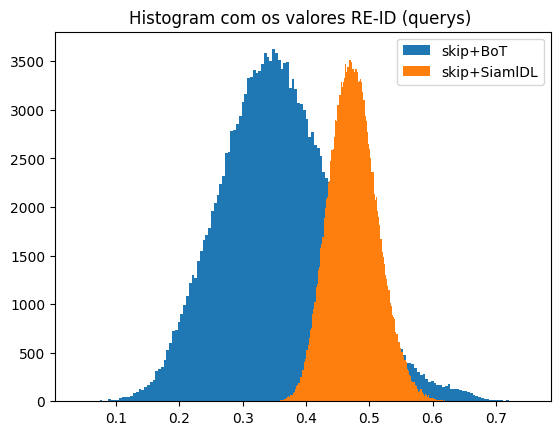

In [17]:
hist_df_outcome_otherCam_skip_BoT           = plt.hist(cosine_similarity_otherCam_skip_BoT          , bins='auto',label='skip+BoT')
hist_df_outcome_otherCam_skip_SiamIDL       = plt.hist(cosine_similarity_otherCam_skip_SiamIDL      , bins='auto',label='skip+SiamlDL')
plt.title("Histogram com os valores RE-ID (querys) ")
plt.legend()

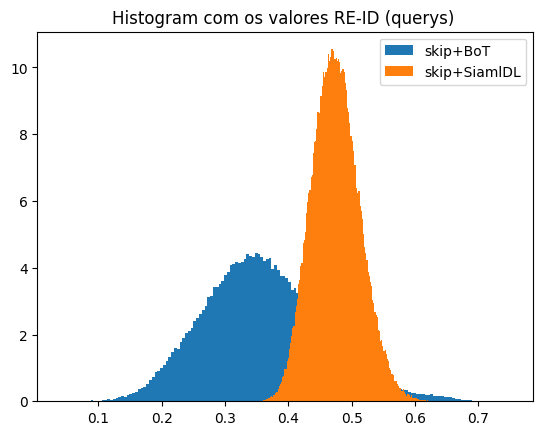

In [18]:
hist_df_outcome_otherCam_skip_Bot     = plt.hist(cosine_similarity_otherCam_skip_BoT    , density=True, bins='auto',label='skip+BoT')
hist_df_outcome_otherCam_skip_SiamIDL = plt.hist(cosine_similarity_otherCam_skip_SiamIDL, density=True, bins='auto',label='skip+SiamlDL')

plt.title("Histogram com os valores RE-ID (querys) ")
plt.legend()

## test OPEN resultGUI dataframe

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.legend_handler import HandlerTuple

In [20]:
def request_data(df, beta, eta, tau):
    cond1 = (df['type']!='TrueSilence') & (df['beta']==beta) & (df['eta']==eta) & (df['tau']==tau)
    return df[cond1]

In [21]:
df_resultGUI_otherCam_skip_BoT     = all_resultGUI[0][0]

In [22]:
df_resultGUI_otherCam_skip_SiamIDL = all_resultGUI[0][1]

In [23]:
df_resultGUI_otherCam_skip_BoT[df_resultGUI_otherCam_skip_BoT['type']=='errorGUI']

,queryAbsPath,qId,qIsPesentGT,beta,eta,tau,highSimilarity,qIsIn_eta,type


In [24]:
hdS1 = df_resultGUI_otherCam_skip_BoT['highSimilarity'].to_numpy()

Text(0.5, 1.0, 'Histogram: max values of REID(baseline) of each tracklet. ')

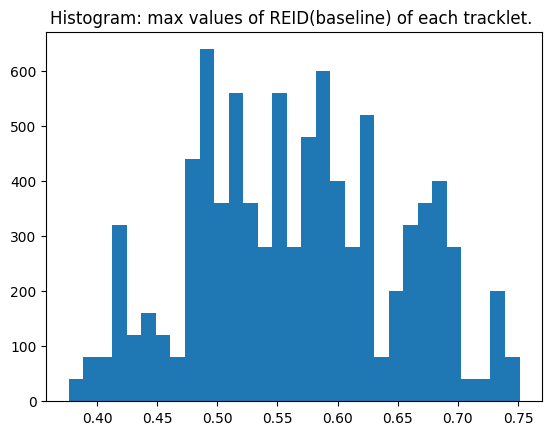

In [25]:
_=plt.hist(hdS1, bins='auto')
plt.title("Histogram: max values of REID(baseline) of each tracklet. ")

In [26]:
dict_type_dfOtherCam = df_resultGUI_otherCam_skip_BoT['type'].value_counts().to_dict()
dict_type_dfOtherCam

{'TrueSilence': 3026,
 'FalseCall': 2574,
 'FalseSilence': 1608,
 'TrueCall': 799,
 'TrueMissedCall': 753}

## FR  = TC / (TC + TMC + FS) 
## TVR = TC / (TC + TMC + FC)

In [27]:
def FR(dictTypes):
    tc  = dictTypes.get('TrueCall')       if dictTypes.get('TrueCall')       else 0
    tmc = dictTypes.get('TrueMissedCall') if dictTypes.get('TrueMissedCall') else 0
    fs  = dictTypes.get('FalseSilence')   if dictTypes.get('FalseSilence')   else 0
    if tc==0:
        return 0
    if (tc + tmc + fs)==0:
        return 0
    return  tc / (tc + tmc + fs)

def TVR(dictTypes):
    tc  = dictTypes.get('TrueCall')       if dictTypes.get('TrueCall')       else 0
    tmc = dictTypes.get('TrueMissedCall') if dictTypes.get('TrueMissedCall') else 0
    fc  = dictTypes.get('FalseCall')      if dictTypes.get('FalseCall')      else 0
    if tc==0:
        return 0
    if (tc+tmc+fc)==0:
        return 0
    return  tc / (tc + tmc + fc)

In [28]:
def processing_data(df, thrs_list, eta, tau):
#     tau        = 10  # [10,100,1000]
#     eta        = 10  #[10,20]
#     thrs_list  = [0.5, 0.6, 0.7, 0.8, 0.98]
    result_FR  = list() 
    result_TVR = list() 
    for thr in thrs_list:
        tmp_df   = request_data(df, thr, eta, tau)
        tmp_dict = tmp_df['type'].value_counts().to_dict()
        result_FR.append(  FR(tmp_dict) )
        result_TVR.append( TVR(tmp_dict) )   
    return result_FR, result_TVR

In [29]:

# rc('mathtext', default='regular')

def plot_results(thrs_list, list_tuples, tau, eta, normalizeY=False, title=None, save_path=None):
    fig = plt.figure(figsize=(12,6))
    ax  = fig.add_subplot(111)
    if title:
        ax.set_title(title,y=1.15, pad=-14)

    ax2 = ax.twinx()

    ax.grid()
    ax.set_xlabel(r'Threshold ($\beta_i$)'+ '\n'+ 
                  r'Tau ($\tau='+str(tau)+'$)' + '\n'+
                  r'Eta ($\eta='+str(eta)+'$)'
                 )
    
    ax.set_ylabel(r'Finding Rate (FR)', color='blue')
    ax2.set_ylabel(r'True Validation Rate (TVR)', color='red')
    if normalizeY:
        ax.set_ylim(0, 1)
        ax2.set_ylim(0, 1)

    ###############################
    lines    = list()
    for j, j_point,k ,k_point ,lb , _alpha in list_tuples:
        min_size = min( len(thrs_list), len(j), len(k) )
        thrs_list= thrs_list[:min_size]
        j        = j[:min_size]
        k        = k[:min_size]
        ln1      = ax.plot(thrs_list, j, j_point, label = lb, alpha=_alpha , markersize = 10)
        ln2      = ax2.plot(thrs_list, k, k_point, label = lb , alpha=_alpha, markersize = 10)
        lines.append((ln1[0] , ln2[0]))
    # added these three lines
#     print(lines)
#     labels = [(l1.get_label(),l2.get_label()) for l1,l2 in lines]
    labels = [l1.get_label() for l1,l2 in lines]
    # ax.legend(lns, labs, loc=0)
#     print(labels)
#     print(len(lines)) 
    ax.legend(lines, labels,bbox_to_anchor=(0., 1.02, 1., .102), 
              loc='lower left', 
              ncol=len(lines), 
              mode="expand", 
              borderaxespad=0., 
              numpoints=1, 
              handler_map={tuple: HandlerTuple(ndivide=None)})
    if save_path:
        nameFigSave = '{}.png'
        if title:
            nameFigSave = nameFigSave.format(title)
        else:
            nameFigSave = nameFigSave.format('save_img')
        fig.savefig(os.path.join(save_path,nameFigSave),dpi=400)   # save the figure to file

#     plt.show()

In [30]:
def CalculateAveragePrecision(rec, prec):
    mrec = []
    mrec.append(0)
    [mrec.append(e) for e in rec]
    mrec.append(1)
    mpre = []
    mpre.append(0)
    [mpre.append(e) for e in prec]
    mpre.append(0)
    for i in range(len(mpre) - 1, 0, -1):
        mpre[i - 1] = max(mpre[i - 1], mpre[i])
    ii = []
    for i in range(len(mrec) - 1):
        if mrec[1+i] != mrec[i]:
            ii.append(i + 1)
    ap = 0
    for i in ii:
        ap = ap + np.sum((mrec[i] - mrec[i - 1]) * mpre[i])
    # return [ap, mpre[1:len(mpre)-1], mrec[1:len(mpre)-1], ii]
    return [ap, mpre[0:len(mpre) - 1], mrec[0:len(mpre) - 1], ii]

## MAX FR and TVR for all cases of max tracklets = [1,5,10,20,40,80]

In [31]:
def FScore_v0(FR, TVR, gamma=1):
    _FR  = float(FR)
    _TVR = float(TVR)
    
    numerator   = float(1 + gamma**2) * (_FR * _TVR)
    denominator = ((float(gamma**2) * _FR) + _TVR)
    if denominator == 0:
        fs = 0
    else:
        fs = numerator / denominator
    return fs

In [32]:
def find_max_fscore(FR_list, TVR_list, gamma=1.0):
    fscores = list()
    for i_FR, j_TVR in zip(FR_list, TVR_list):
        fs = FScore_v0(i_FR, j_TVR, gamma=gamma)
        fscores.append(fs)
    return fscores

In [33]:
# thrs_list = linspace(start=0.2, end=0.98, step=0.02) 
thrs_list = linspace(start=0.2, end=0.6, step=0.02) 
# ETA rank (ex: 10, 20, 30)

max_tracklets = [1,5,10,20,40,80]


# MAX FR and TVR with BoT
for i, (df_resultGUI_BoT, df_resultGUI_SiamIDL) in zip(max_tracklets, all_resultGUI):
 
    # PROCESSING
    FR_skip_BoT_list, TVR_skip_BoT_list = processing_data(df_resultGUI_BoT, thrs_list , eta=20, tau=1000 )
    fscores_list = find_max_fscore(FR_skip_BoT_list, TVR_skip_BoT_list)
    fs_max       = max(fscores_list)
    idx          = fscores_list.index(fs_max)            
    print("[ \'Skip+BoT_e{}f\' ,".format(i), FR_skip_BoT_list[idx]," , ", TVR_skip_BoT_list[idx],"],")
    
    
    
# MAX FR and TVR with siamIDL
for i, (df_resultGUI_BoT, df_resultGUI_SiamIDL) in zip(max_tracklets, all_resultGUI):
      
    # PROCESSING
    FR_skip_SiamIDL_list, TVR_skip_SiamIDL_list = processing_data(df_resultGUI_SiamIDL, thrs_list , eta=20, tau=1000 )
    fscores_list = find_max_fscore(FR_skip_SiamIDL_list, TVR_skip_SiamIDL_list)
    fs_max       = max(fscores_list)
    idx          = fscores_list.index(fs_max)            
    print("[ \'Skip+SiamIDL_e{}f\' ,".format(i), FR_skip_SiamIDL_list[idx]," , ", TVR_skip_SiamIDL_list[idx],"],")
    

[ 'Skip+BoT_e1f' , 0.5189873417721519  ,  0.20812182741116753 ],
[ 'Skip+BoT_e5f' , 0.6708860759493671  ,  0.27461139896373055 ],
[ 'Skip+BoT_e10f' , 0.8354430379746836  ,  0.3157894736842105 ],
[ 'Skip+BoT_e20f' , 0.8734177215189873  ,  0.3415841584158416 ],
[ 'Skip+BoT_e40f' , 0.8354430379746836  ,  0.36666666666666664 ],
[ 'Skip+BoT_e80f' , 0.810126582278481  ,  0.31683168316831684 ],
[ 'Skip+SiamIDL_e1f' , 0.5443037974683544  ,  0.2037914691943128 ],
[ 'Skip+SiamIDL_e5f' , 0.7215189873417721  ,  0.2626728110599078 ],
[ 'Skip+SiamIDL_e10f' , 0.7215189873417721  ,  0.296875 ],
[ 'Skip+SiamIDL_e20f' , 0.8481012658227848  ,  0.3059360730593607 ],
[ 'Skip+SiamIDL_e40f' , 0.8734177215189873  ,  0.32242990654205606 ],
[ 'Skip+SiamIDL_e80f' , 0.810126582278481  ,  0.29767441860465116 ],


# PLOT all results

In [34]:
# thrs_list = linspace(start=0.2, end=0.98, step=0.02) 
thrs_list = linspace(start=0.2, end=0.6, step=0.02) 
# ETA rank (ex: 10, 20, 30)

In [35]:
all_FR_TVR = None
all_FR_TVR = list()

for curr_df in all_resultGUI:
    FR_Skip_BoT,     TVR_Skip_BoT     = processing_data(curr_df[0], thrs_list , eta=20, tau=1000 )
    FR_Skip_SiamlDL, TVR_Skip_SiamlDL = processing_data(curr_df[1], thrs_list , eta=20, tau=1000 )
   
    all_FR_TVR.append([[FR_Skip_BoT,     TVR_Skip_BoT    ],
                       [FR_Skip_SiamlDL, TVR_Skip_SiamlDL],
                      ])

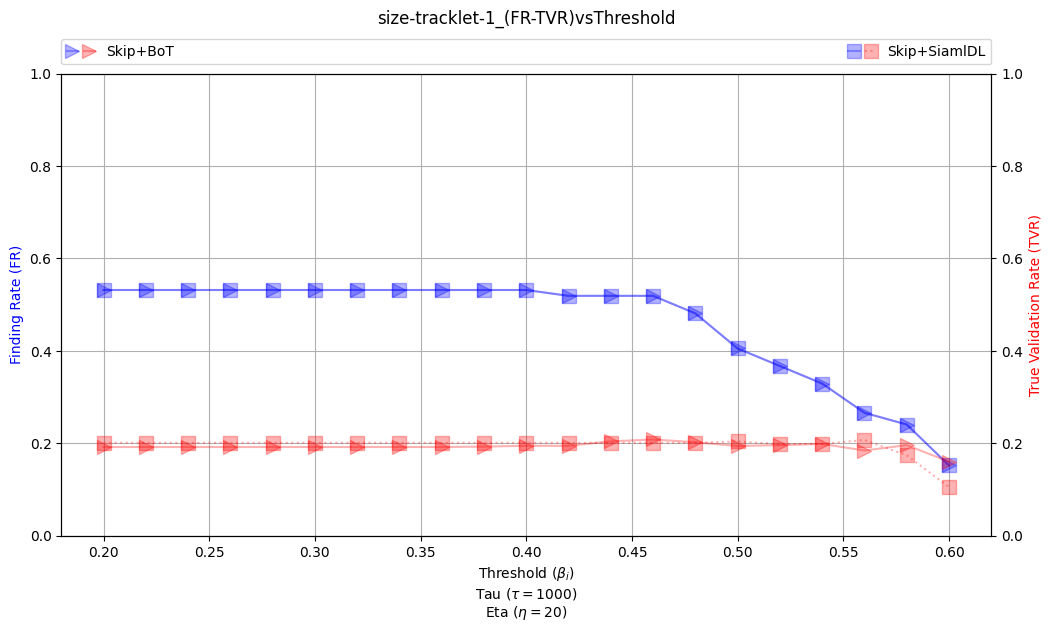

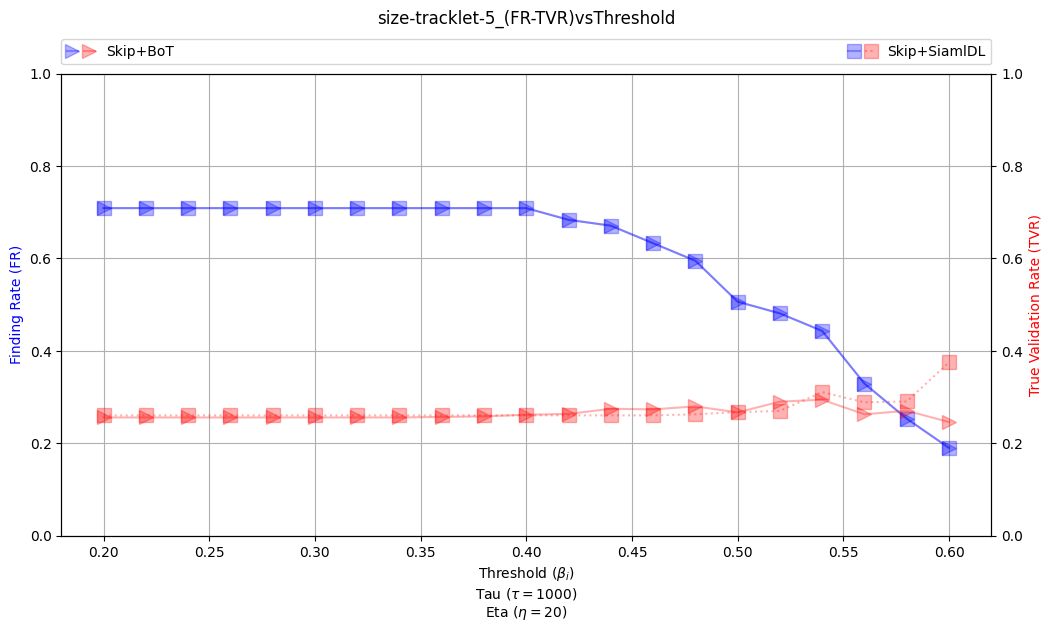

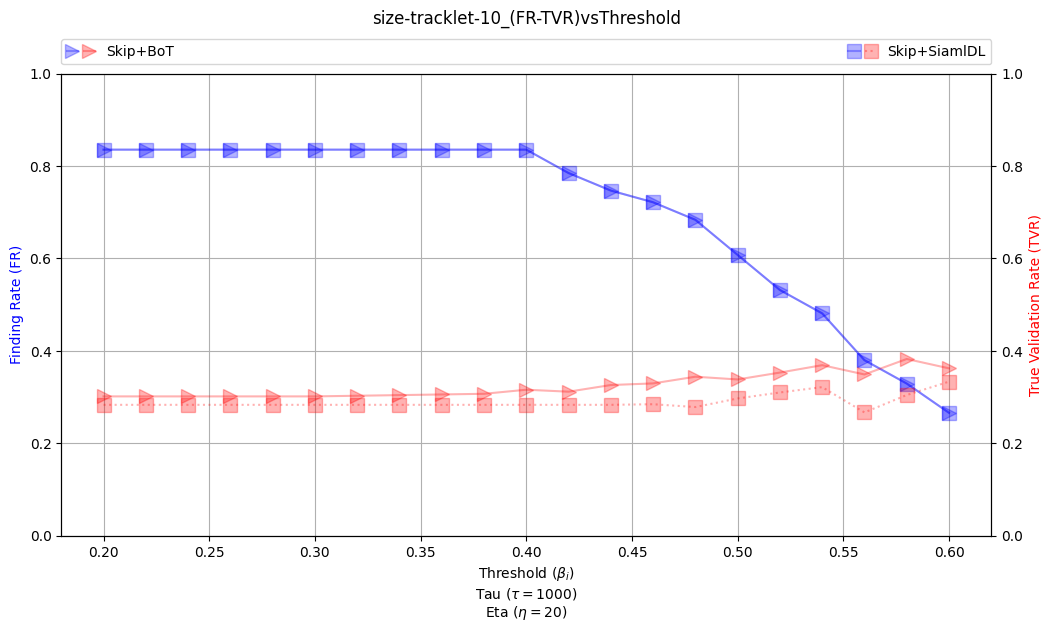

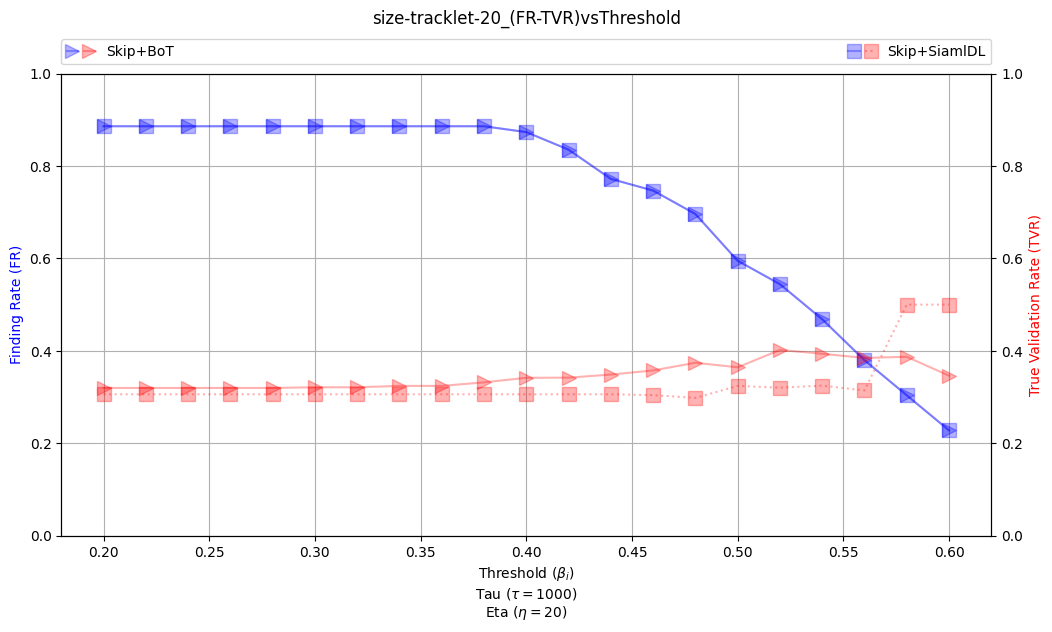

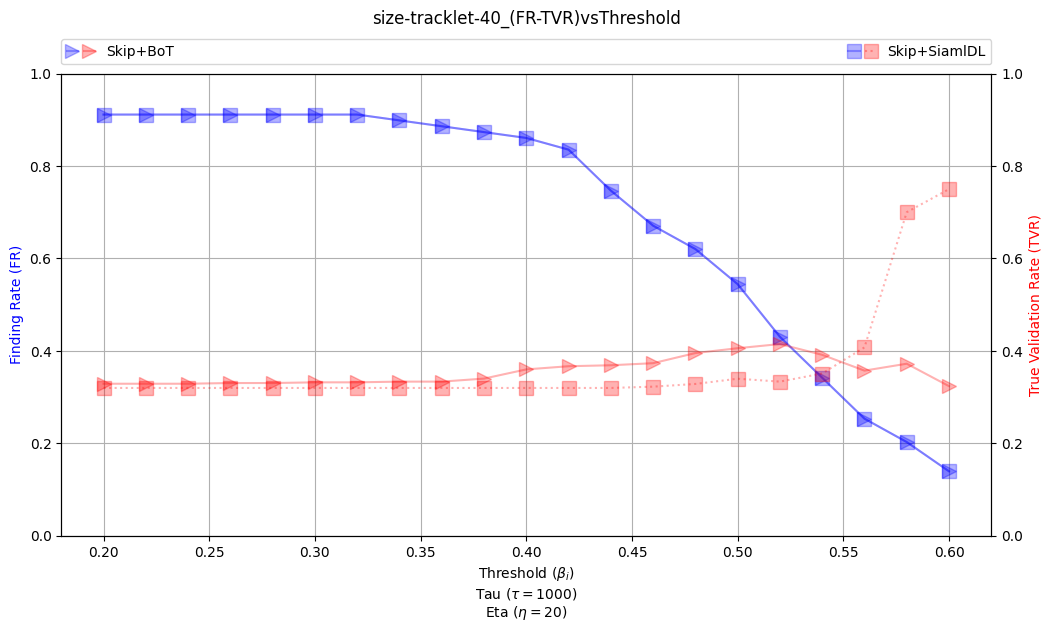

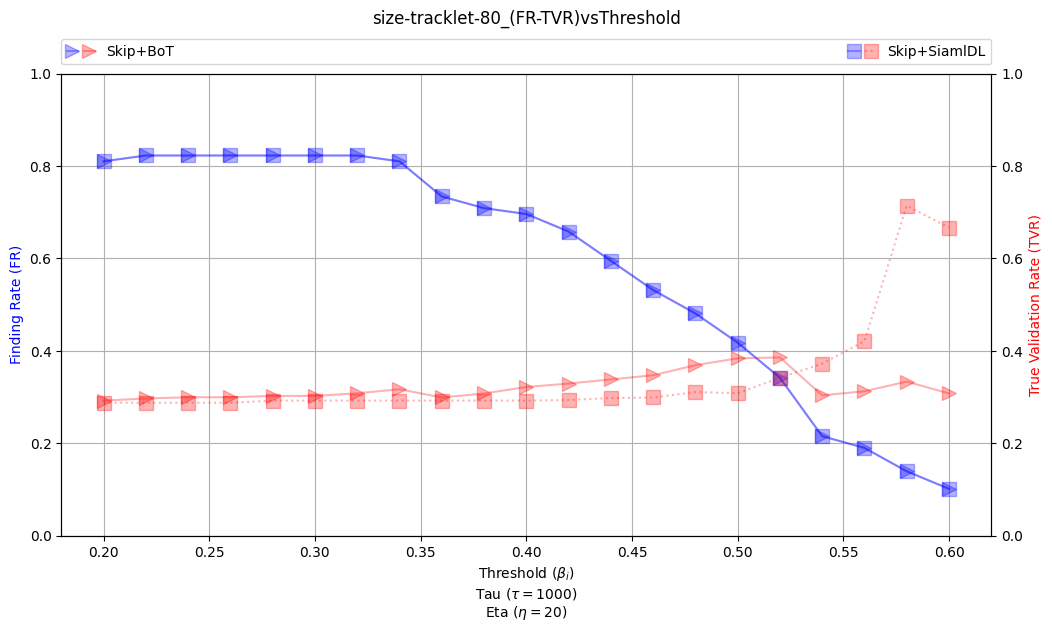

In [36]:

list_max_tracklet            = [1,5,10,20,40,80]
prefix_max_tracklet          = 'size-tracklet-{}'

count = 0
for (FR_BoT, TVR_BoT), (FR_SiamIDL, TVR_SiamIDL) in all_FR_TVR:
#     lines =[( FR_TVR[0][0],'>b-' ,FR_TVR[0][1], '>r-' , r'TrADe+BoT'        , 0.3 ),
#             ( FR_TVR[1][0],'sb-' ,FR_TVR[1][1], 'sr:' , r'TrADe+SiamlDL',  0.3) ]

    lines =[( FR_BoT,'>b-', TVR_BoT    , '>r-' , r'Skip+BoT'    , 0.3 ),
            ( FR_BoT,'sb-', TVR_SiamIDL, 'sr:' , r'Skip+SiamlDL',  0.3) ]

    
    plot_results(thrs_list, 
                 lines, 
                 tau = 1000, 
                 eta = 20, 
                 normalizeY = True,
                 title      = prefix_max_tracklet.format(str(list_max_tracklet[count])+'_(FR-TVR)vsThreshold'),
                 save_path  = path_save_imgs,
                 )
    count+=1
    


# Average Precision

In [37]:
import pandas
import numpy
from itertools import product

def AP_calculate(list_dfs):
    ap_results = list()
    tau        = [1000]

    for _tau in tau:
        eta   = [20]
        cols1 = ['AP']
        cols2 = ['$\eta$={}'.format(eta[0]),
                ]
        tmp   = list(range(len(cols1)*len(cols2)))
        df    = pandas.DataFrame(columns=tmp)

        df.columns = pandas.MultiIndex.from_tuples(list(product( cols1, cols2)))
        df.insert(loc=0, column=('$\tau$ = {}'.format(_tau), 'Method'), value=['Skip+BoT','Skip+SiamlDL',])
        # df.style.set_properties(**{'text-align': 'center'})

        iterate  = list(product(list_dfs, eta))
        list_tmp = list()
    #     print(iterate)
        for _df, _eta in  iterate:
            _recall, _precision  = processing_data(_df, thrs_list , eta=_eta, tau=_tau )
            _recall, _precision  = _recall[::-1], _precision[::-1]
            [ap, mpre, mrec, ii] = CalculateAveragePrecision(_recall, _precision)
            list_tmp.append(ap)

        list_tmp = np.asarray(list_tmp)

#         print(list_tmp.shape)
        list_tmp = list_tmp.reshape(2,1)
#         print(list_tmp.shape)
        df.iloc[:,1:5] = list_tmp
        ap_results.append(df)
        return ap_results[0]

In [38]:
list_dfs = [all_resultGUI[5][0],
            all_resultGUI[5][1], 
           ]

In [39]:
AP_calculate(list_dfs)

,$\tau$ = 1000,AP
,Method,$\eta$=20
0,Skip+BoT,0.292635
1,Skip+SiamlDL,0.286973


# F-score

Fγ = (1 + γ^2) * (FR * TVR) / ((γ^2 * FR) + TVR)

In [40]:
def FScore(_FR, _TVR, gamma=1):
    numerator   = (1 + gamma**2) * (_FR * _TVR)
    denominator = ((gamma**2 * _FR) + _TVR)
    if denominator == 0:
        fs = 0
    else:
        fs = numerator / denominator
    return fs

In [41]:
def processing_data2(df, thrs_list, eta, tau):
#     tau        = 10  # [10,100,1000]
#     eta        = 10  #[10,20]
#     thrs_list  = [0.5, 0.6, 0.7, 0.8, 0.98]
    result_FR  = list() 
    result_TVR = list() 
    for thr in thrs_list:
        tmp_df   = request_data(df, thr, eta, tau)
        tmp_dict = tmp_df['type'].value_counts().to_dict()
        result_FR.append(  FR(tmp_dict) )
        result_TVR.append( TVR(tmp_dict) )   
    return result_FR, result_TVR

In [42]:
import pandas
import numpy
from itertools import product


def FScore_calculate(list_dfs):
    
    fscore_results = list()
    tau          = [1000 ]

    for _tau in tau:
        eta     = [20]
        cols1   = ['$F_{\gamma=0.5}$ Score', '$F_{\gamma=1.0}$ Score', '$F_{\gamma=2.0}$ Score']
        gammas  = [0.5, 1, 2]
        cols2   = ['$\eta$={}'.format(eta[0]),
                  ]
        tmp = list(range(len(eta)*len(gammas)))
        df  = pandas.DataFrame(columns=tmp)

        df.columns = pandas.MultiIndex.from_tuples(list(product(cols1, cols2)))
        df.insert(loc=0, column=('$\tau$ = {}'.format(_tau), 'Method'), value=['Skip+BoT','Skip+SiamlDL'])
        # df.style.set_properties(**{'text-align': 'center'})

        iterate  = list(product(list_dfs, gammas, eta))

        list_tmp = list()
    #     print(iterate)
        for _df, _gamma, _eta in  iterate:
    #         print( _gamma, _eta)
            FR_list, TVR_list  = processing_data2(_df, thrs_list , eta=_eta, tau=_tau )
            fscores = list()
            for _FR, _TVR in zip(FR_list, TVR_list):
                fs = FScore(_FR, _TVR, gamma=_gamma)
                fscores.append(fs)
            fs_max = max(fscores)
            list_tmp.append(fs_max)

        list_tmp = np.asarray(list_tmp)
        list_tmp = list_tmp.reshape(2,3)
#         print(list_tmp.shape)
        df.iloc[:,1:4] = list_tmp
        fscore_results.append(df)
    return fscore_results[0]

In [43]:
list_dfs = [all_resultGUI[5][0],
            all_resultGUI[5][1], 
           ]

In [44]:
FScore_calculate(list_dfs)

,$\tau$ = 1000,$F_{\gamma=0.5}$ Score,$F_{\gamma=1.0}$ Score,$F_{\gamma=2.0}$ Score
,Method,$\eta$=20,$\eta$=20,$\eta$=20
0,Skip+BoT,0.617761,0.455516,0.390071
1,Skip+SiamlDL,0.602637,0.435374,0.349428


# Test for all cases  [1,5,10,20,40,80]

## AP_calculate 

In [102]:
max_tracklets = [1,5,10,20,40,80]

for i, j in zip(max_tracklets, all_resultGUI):
    name_row  = AP_calculate(j).loc[0][0]
    value_row = AP_calculate(j).loc[0][1]
    print("'Skip+BoT_e{}f', ".format(i),",", value_row)
    
for i, j in zip(max_tracklets, all_resultGUI):
    name_row  = AP_calculate(j).loc[1][0]
    value_row = AP_calculate(j).loc[1][1]
    print("'Skip+SiamIDL_e{}f', ".format(i),",", value_row)


'Skip+BoT_e1f',  , 0.11047391605445964
'Skip+BoT_e5f',  , 0.2040082444488555
'Skip+BoT_e10f',  , 0.3007394114092046
'Skip+BoT_e20f',  , 0.34131602818891543
'Skip+BoT_e40f',  , 0.36012074210147005
'Skip+BoT_e80f',  , 0.2926346228167296
'Skip+SiamIDL_e1f',  , 0.11417516332786627
'Skip+SiamIDL_e5f',  , 0.21310453546148678
'Skip+SiamIDL_e10f',  , 0.24368835360515975
'Skip+SiamIDL_e20f',  , 0.29070433679977675
'Skip+SiamIDL_e40f',  , 0.3367741723831414
'Skip+SiamIDL_e80f',  , 0.28697289828918326


In [103]:
max_tracklets = [1,5,10,20,40,80]

for i, j in zip(max_tracklets, all_resultGUI):
 
    name_row  = FScore_calculate(j).loc[0][0]
    fscore_05_row = FScore_calculate(j).loc[0][1]
    fscore_10_row = FScore_calculate(j).loc[0][2]
    fscore_20_row = FScore_calculate(j).loc[0][3]
    print("'Skip+BoT_e{}f', ".format(i), ",", fscore_05_row, ",", fscore_10_row, ",", fscore_20_row)
    
    
for i, j in zip(max_tracklets, all_resultGUI): 
    name_row  = FScore_calculate(j).loc[1][0]
    fscore_05_row = FScore_calculate(j).loc[1][1]
    fscore_10_row = FScore_calculate(j).loc[1][2]
    fscore_20_row = FScore_calculate(j).loc[1][3]
    print("'Skip+SiamIDL_e{}f', ".format(i), ",", fscore_05_row, ",", fscore_10_row, ",", fscore_20_row)
    
    

'Skip+BoT_e1f',  , 0.39961013645224175 , 0.29710144927536236 , 0.23644752018454443
'Skip+BoT_e5f',  , 0.5283018867924527 , 0.3897058823529412 , 0.3153153153153153
'Skip+BoT_e10f',  , 0.6285714285714286 , 0.45833333333333326 , 0.38696537678207743
'Skip+BoT_e20f',  , 0.666023166023166 , 0.49110320284697506 , 0.42406311637080873
'Skip+BoT_e40f',  , 0.6754221388367729 , 0.5096525096525096 , 0.42743538767395634
'Skip+BoT_e80f',  , 0.6177606177606176 , 0.4555160142348754 , 0.3900709219858157
'Skip+SiamIDL_e1f',  , 0.411214953271028 , 0.296551724137931 , 0.23293607800650057
'Skip+SiamIDL_e5f',  , 0.5347091932457786 , 0.38513513513513514 , 0.32586558044806513
'Skip+SiamIDL_e10f',  , 0.5805243445692884 , 0.42066420664206644 , 0.34003091190108187
'Skip+SiamIDL_e20f',  , 0.6261682242990655 , 0.44966442953020136 , 0.3647798742138365
'Skip+SiamIDL_e40f',  , 0.6542056074766356 , 0.4709897610921502 , 0.3776223776223776
'Skip+SiamIDL_e80f',  , 0.6026365348399247 , 0.435374149659864 , 0.349428208386277

# plot AP

In [104]:
FR_eta_20_tau_1000_skip_BoT, TVR_eta_20_tau_1000_skip_BoT = processing_data(all_resultGUI[0][0], thrs_list , eta=20, tau=1000 )


Area Under Curve: 0.11


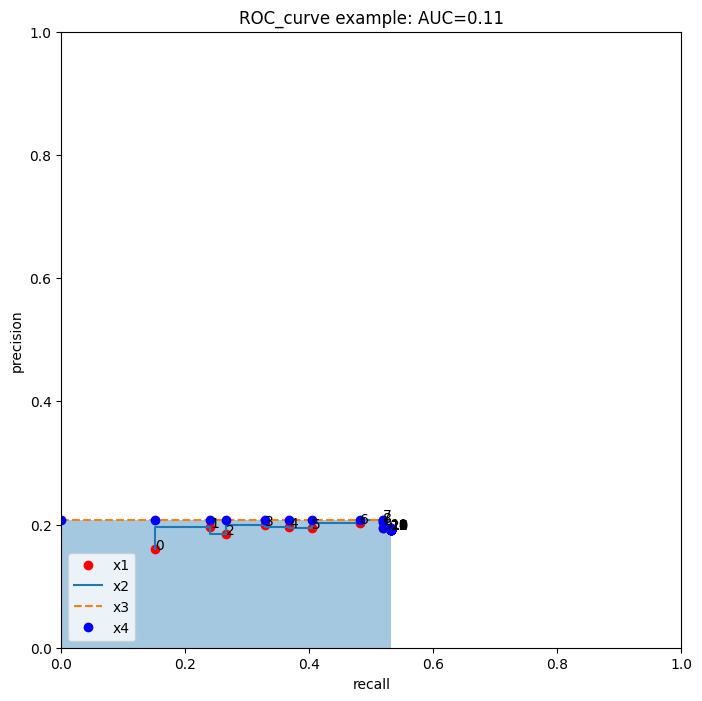

In [105]:
import random
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

recall    = FR_eta_20_tau_1000_skip_BoT[::-1]
precision = TVR_eta_20_tau_1000_skip_BoT[::-1]


area = 0
# area = auc(precision,recall)
[area, mpre, mrec, ii] = CalculateAveragePrecision(recall,precision)
# [area, _, _, _] = CalculateAveragePrecision(recall,precision)
print("Area Under Curve: %0.2f" % area)




plt.figure(figsize=(8,8))
plt.plot(recall, precision, 'ro', label='x1')
plt.plot(recall, precision, label='x2', drawstyle='steps')
plt.step(mrec,   mpre, '--', label='x3')
plt.plot(mrec,   mpre, 'bo', label='x4')

plt.fill_between(mrec,   mpre, step="pre", alpha=0.4)


# plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

for i, _ in enumerate(recall):
    plt.annotate(i, (recall[i], precision[i]))

plt.xlabel('recall')
plt.ylabel('precision')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.title('ROC_curve example: AUC=%0.2f' % area)
plt.legend(loc="lower left")
plt.show()

# Test FPR vs TPR

In [106]:
def FPR(dictTypes):
    if isinstance(dictTypes,dict) is False:
        raise Exception('dictTypes is not a dictionary')
    # FPR =  ( TMC + FC )  / ( TMC  + FC +  TS )
    tmc = dictTypes.get('TrueMissedCall') if dictTypes.get('TrueMissedCall') else 0
    fc  = dictTypes.get('FalseCall')      if dictTypes.get('FalseCall')      else 0
    ts  = dictTypes.get('TrueSilence')    if dictTypes.get('TrueSilence')    else 0
    
    if (tmc + fc + ts)==0:
        return 0
#     return  (tmc + fc) / (tmc + fc + ts)
#     print("tmc + fc + ts :", tmc, fc, ts, "->>: ", tmc + fc + ts)
#     print("result FPR: ", (fc) / (tmc + fc + ts))
    return  (fc) / (fc + tmc + ts)

def TPR(dictTypes):
    if isinstance(dictTypes,dict) is False:
        raise Exception('dictTypes is not a dictionary')
    # TPR =  ( TC )  / ( TC + TMC +  FS )
    tmc = dictTypes.get('TrueMissedCall') if dictTypes.get('TrueMissedCall') else 0
    tc  = dictTypes.get('TrueCall')       if dictTypes.get('TrueCall')       else 0
    fs  = dictTypes.get('FalseSilence')   if dictTypes.get('FalseSilence')   else 0
    if (tmc + tc + fs)==0:
        return 0
#     print("tc + tmc + fs :", tc, tmc, fs, "->>: ", tmc + tc + fs)
#     print("result TPR: ", (tc) / (tc + tmc + fs))
    return  (tc) / (tc + tmc + fs)


In [107]:
def ROC_curve(df, thrs_list, eta, tau):
    result_FPR = list() 
    result_TPR = list() 
    for thr in thrs_list:
        tmp_df     = None
        tmp_dict   = None
        tmp_df   = request_data(df, thr, eta, tau)
#         print("tmp_df: ",tmp_df)

        tmp_dict = tmp_df['type'].value_counts().to_dict()

#         print("tmp_dict: ",tmp_dict)
#         print("thr: ", thr)
#         print("FPR: ", FPR(tmp_dict))
#         print("TPR: ", TPR(tmp_dict))
        result_FPR.append( FPR(tmp_dict) )
        result_TPR.append( TPR(tmp_dict) )   
    return result_FPR, result_TPR

In [108]:

df_resultGUI_otherCam_skip_BoT = all_resultGUI[0][0] # df_resultGUI_otherCam_skip_BoT

In [109]:
FPR_eta_20_tau_1000, TPR_eta_20_tau_1000 = ROC_curve(df_resultGUI_otherCam_skip_BoT, thrs_list , eta=20, tau=1000 )


Area Under Curve: 0.00


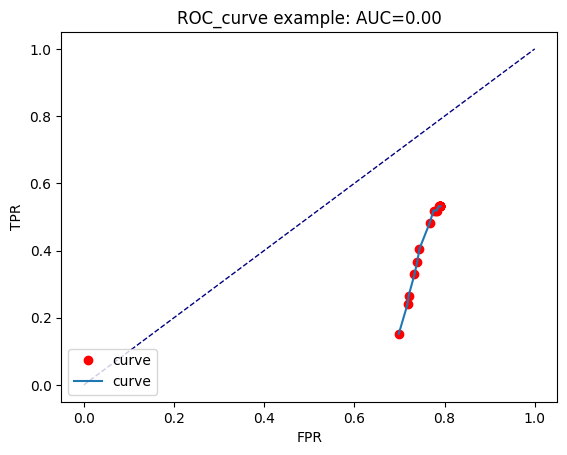

In [110]:
import random
import pylab as pl
from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

FPR, TPR = ROC_curve(df_resultGUI_otherCam_skip_BoT, thrs_list , eta=20, tau=1000 )

area = 0
# area = auc(FPR, TPR)
# area = auc(precision,recall)
print("Area Under Curve: %0.2f" % area)

pl.clf()
pl.plot(FPR, TPR, 'ro', label='curve')
pl.plot(FPR, TPR, label='curve')
# pl.step(recall, precision, where='post', label='step')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

pl.xlabel('FPR')
pl.ylabel('TPR')
# pl.ylim([0.0, 1.05])
# pl.xlim([0.0, 1.0])
pl.title('ROC_curve example: AUC=%0.2f' % area)
pl.legend(loc="lower left")
pl.show()